Neuronal Network using pytorch 

import all libraries 

In [14]:
import os
import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import ResNet50_Weights
import torch.optim as optim
import re
from torch.nn.utils.rnn import pad_sequence

from PIL import Image

import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

Split dataset

In [ ]:

# Base directory of your dataset
dataset_dir = 'dataset'
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

# Create directories for the datasets if they don't exist
for dir_name in [train_dir, val_dir, test_dir]:
    for class_name in ["Play", "Time_Between", "Pass", "Run", "Punt", "Kick-Off", "Field_Goal"]:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

# Group and split all frames according to their videos
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        # Collecting all videos and their frames
        video_frames = {}
        augmented_frames = []  # For augmented frames
        for frame in os.listdir(class_dir):
            if frame.startswith("aug__"):
                augmented_frames.append(frame)  # Collect augmented frames
            elif '_frame_' in frame and frame.endswith('.jpg'):
                video_name, frame_num = frame.split('_frame_')
                frame_num = frame_num.split('.jpg')[0]
                if video_name not in video_frames:
                    video_frames[video_name] = []
                video_frames[video_name].append(frame)

        # Splitting videos into training, validation, and test sets
        videos = list(video_frames.keys())
        train_videos, temp_videos = train_test_split(videos, test_size=0.3, random_state=42)
        val_videos, test_videos = train_test_split(temp_videos, test_size=0.5, random_state=42)

        # Assigning frames to their respective sets
        for video in train_videos:
            for frame in video_frames[video]:
                shutil.copy(os.path.join(class_dir, frame), os.path.join(train_dir, class_name, frame))
        for video in val_videos:
            for frame in video_frames[video]:
                shutil.copy(os.path.join(class_dir, frame), os.path.join(val_dir, class_name, frame))
        for video in test_videos:
            for frame in video_frames[video]:
                shutil.copy(os.path.join(class_dir, frame), os.path.join(test_dir, class_name, frame))

        # Randomly splitting the augmented frames
        if augmented_frames:
            train_aug, temp_aug = train_test_split(augmented_frames, test_size=0.3, random_state=42)
            val_aug, test_aug = train_test_split(temp_aug, test_size=0.5, random_state=42)
            for frame in train_aug:
                shutil.copy(os.path.join(class_dir, frame), os.path.join(train_dir, class_name, frame))
            for frame in val_aug:
                shutil.copy(os.path.join(class_dir, frame), os.path.join(val_dir, class_name, frame))
            for frame in test_aug:
                shutil.copy(os.path.join(class_dir, frame), os.path.join(test_dir, class_name, frame))
        else:
            print("No augmented frames found in", class_dir)

print("Data has been successfully split.")


CNN & LSTM

In [10]:
class CNNLSTMModel(nn.Module):
    def __init__(self, num_classes, latent_dim=256, lstm_layers=2):
        super(CNNLSTMModel, self).__init__()
        # Load a pretrained ResNet-50 model
        resnet = models.resnet50(pretrained=True)
        # Remove the last Fully-Connected layer to extract features
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])
        
        # LSTM Module
        self.lstm = nn.LSTM(input_size=2048, hidden_size=latent_dim, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(latent_dim, num_classes)  # Classification layer

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        # Process frames through the CNN
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        c_out = c_out.view(batch_size, timesteps, -1)
        
        # Process the feature sequence through the LSTM
        lstm_out, _ = self.lstm(c_out)
        # Use only the last output for classification
        final_output = self.fc(lstm_out[:, -1, :])
        return final_output


# Model instantiation
model = CNNLSTMModel(num_classes=7)  # Adjust number of classes

# Output the layers of the model
print(model)

# Or output specific layers
print("CNN Layers:")
print(model.cnn)

print("\nLSTM Layers:")
print(model.lstm)

print("\nClassification Layer:")
print(model.fc)

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64,

In [11]:
# Custom Dataset
class FootballDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.classes = os.listdir(data_dir)
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.imgs = self.make_dataset()

    def make_dataset(self):
        images = []
        for cls in self.classes:
            class_dir = os.path.join(self.data_dir, cls)
            if not os.path.isdir(class_dir):
                continue
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                item = (img_path, self.class_to_idx[cls])
                images.append(item)
        return images

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path, target = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        img = transform(img)
        return img, target

# Set data directories
train_data_dir = 'train'
val_data_dir = 'val'
test_data_dir = 'test'

# Create datasets
train_dataset = FootballDataset(train_data_dir)
val_dataset = FootballDataset(val_data_dir)
test_dataset = FootballDataset(test_data_dir)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = CNNLSTMModel(num_classes=len(train_dataset.classes)).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1, 3, 224, 224)  # Anpassung an (Batch, Time, C, H, W)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Ausgabe der Statistiken nach jedem Batch
            if (i + 1) % 10 == 0:  # Optional: Update alle 10 Batches
                print(f"Epoch {epoch+1}, Batch {i+1}, "
                      f"Batch Loss: {loss.item():.4f}, "
                      f"Batch Acc: {100. * predicted.eq(labels).sum().item() / labels.size(0):.2f}%")

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Validation am Ende jeder Epoche
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.view(inputs.size(0), -1, 3, 224, 224)  # Anpassung an (Batch, Time, C, H, W)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        print(f"End of Epoch {epoch+1}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1, Batch 10, Batch Loss: 1.4092, Batch Acc: 46.88%
Epoch 1, Batch 20, Batch Loss: 1.3423, Batch Acc: 53.12%
Epoch 1, Batch 30, Batch Loss: 1.1858, Batch Acc: 50.00%
Epoch 1, Batch 40, Batch Loss: 1.4939, Batch Acc: 40.62%
Epoch 1, Batch 50, Batch Loss: 1.2418, Batch Acc: 37.50%
Epoch 1, Batch 60, Batch Loss: 1.1833, Batch Acc: 53.12%
Epoch 1, Batch 70, Batch Loss: 1.5862, Batch Acc: 31.25%
Epoch 1, Batch 80, Batch Loss: 1.4166, Batch Acc: 37.50%
Epoch 1, Batch 90, Batch Loss: 1.3094, Batch Acc: 50.00%
Epoch 1, Batch 100, Batch Loss: 1.4379, Batch Acc: 31.25%
Epoch 1, Batch 110, Batch Loss: 1.1564, Batch Acc: 56.25%
Epoch 1, Batch 120, Batch Loss: 1.3716, Batch Acc: 43.75%
Epoch 1, Batch 130, Batch Loss: 1.2458, Batch Acc: 40.62%
Epoch 1, Batch 140, Batch Loss: 1.1995, Batch Acc: 43.75%
Epoch 1, Batch 150, Batch Loss: 1.2365, Batch Acc: 53.12%
Epoch 1, Batch 160, Batch Loss: 1.5622, Batch Acc: 37.50%
Epoch 1, Batch 170, Batch Loss: 1.6892, Batch Acc: 21.88%
Epoch 1, Batch 180, Bat

Save Model 

In [13]:
# saving trained model

torch.save(model.state_dict(), 'cnn_lstm_model1.pth')
print("Model successfully saved.")

Model successfully saved.


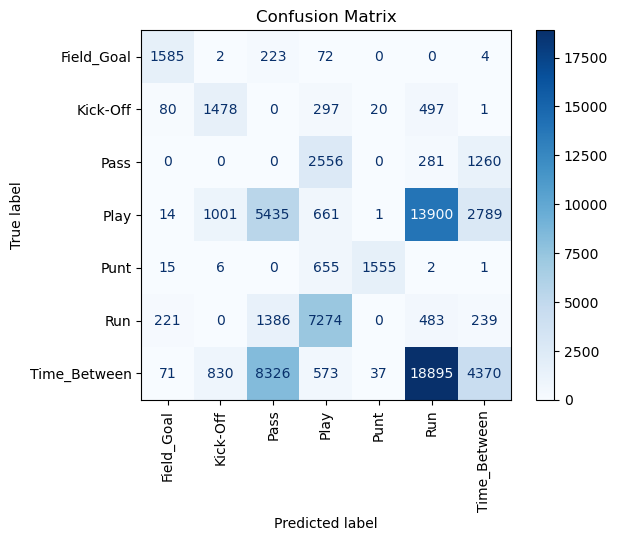

In [15]:
# Function for calculating and displaying the confusion matrix
def plot_confusion_matrix(model, data_loader, classes):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1, 3, 224, 224)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Class list from the dataset
classes = train_dataset.classes

# Plot confusion matrix for the validation dataset
plot_confusion_matrix(model, val_loader, classes)
